In [2]:
! pip install lazypredict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 84.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 9.7 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import all_estimators
from sklearn.base import RegressorMixin
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import VarianceThreshold

import lazypredict
from lazypredict.Supervised import LazyRegressor

from random import randint

## Pubchem Fingerprints

The earlier Lipinski Descriptors give an overview of how drug-like a molecule is, showing how suitable a substance could be for oral consumption.The simplicity of these descriptors makes them appropriate to conduct exploratory data analysis with. Pubchem fingerprints, on the other hand, can give a more microscopic view of chemicals, as they have hundreds of descriptors for each indiividual molecule in a protein, making them ideal for ML models to learn from.

In [4]:
# Extract Datasets containing fingerprints
df_protease = pd.read_csv('protease_pubchem_fp.csv')
df_kat5 = pd.read_csv('kat5_pubchem_fp.csv')
df_ccr5 = pd.read_csv('ccr5_pubchem_fp.csv')

## CCR Fingerprints

In [5]:
X = df_ccr5.drop('pIC50', axis=1)
X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2956,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2957,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2958,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2959,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [6]:
Y = df_ccr5.pIC50
Y

0      6.47
1      7.55
2      8.00
3      7.46
4      7.82
       ... 
2956   8.60
2957   8.08
2958   7.80
2959   8.10
2960   7.72
Name: pIC50, Length: 2961, dtype: float64

In [7]:
X.shape

(2961, 881)

In [8]:
Y.shape

(2961,)

In [9]:
# Remove low variance features
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)

In [10]:
X.shape

(2961, 154)

In [11]:
# Split the model into 80-20 format
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [12]:
X_train.shape, Y_train.shape

((2368, 154), (2368,))

In [13]:
X_test.shape, Y_test.shape

((593, 154), (593,))

In [37]:
# These Regressors were removed because of other regressors tend to do better on datasets like ours, with a
# sparesely populated feature set (X data)

removed_regressors = [
    "TheilSenRegressor",
    "ARDRegression", 
    "CCA", 
    "IsotonicRegression", 
    "StackingRegressor",
    "MultiOutputRegressor", 
    "MultiTaskElasticNet", 
    "MultiTaskElasticNetCV", 
    "MultiTaskLasso", 
    "MultiTaskLassoCV", 
    "PLSCanonical", 
    "PLSRegression", 
    "QuantileRegressor", 
    "RadiusNeighborsRegressor", 
    "RegressorChain", 
    "VotingRegressor", 
]

REGRESSORS = [
    est
    for est in all_estimators()
    if (issubclass(est[1], RegressorMixin) and (est[0] not in removed_regressors))
]


clf = LazyRegressor(custom_metric=None, verbose=1, ignore_warnings=False, regressors = REGRESSORS)

In [38]:
models, predictions = clf.fit(X_train, X_test, Y_train, Y_test)

'tuple' object has no attribute '__name__'
Invalid Regressor(s)
 10%|█         | 4/39 [00:02<00:15,  2.31it/s]{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.5178790817273122, 'Adjusted R-Squared': 0.3483662474487873, 'RMSE': 0.9943986686009023, 'Time taken': 0.21472620964050293}
{'Model': 'DummyRegressor', 'R-Squared': -0.007532435274105964, 'Adjusted R-Squared': -0.36177899927459056, 'RMSE': 1.4375139395074146, 'Time taken': 0.025852680206298828}
{'Model': 'ElasticNet', 'R-Squared': 0.032900296411533136, 'Adjusted R-Squared': -0.307130192978019, 'RMSE': 1.408374560222409, 'Time taken': 0.040869712829589844}
 21%|██        | 8/39 [00:14<01:03,  2.06s/it]{'Model': 'ElasticNetCV', 'R-Squared': 0.4321761829481533, 'Adjusted R-Squared': 0.23253036599385113, 'RMSE': 1.0791687208095213, 'Time taken': 11.698293447494507}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.518522124005859, 'Adjusted R-Squared': 0.3492353822179647, 'RMSE': 0.9937352937901545, 'Time taken': 0.15372371673583984}
 2

In [39]:
# Performance table of the test set (20% subset) based on training data (80% subset)
predictions

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
RandomForestRegressor,0.48,0.61,0.89,2.48
HistGradientBoostingRegressor,0.47,0.61,0.90,1.16
SVR,0.47,0.61,0.90,1.14
MLPRegressor,0.47,0.61,0.90,24.64
NuSVR,0.47,0.60,0.90,0.90
BaggingRegressor,0.45,0.59,0.92,0.43
KNeighborsRegressor,0.44,0.59,0.92,0.13
GradientBoostingRegressor,0.40,0.56,0.95,1.12
ExtraTreesRegressor,0.37,0.54,0.98,3.39


[(0.0, 1.0)]

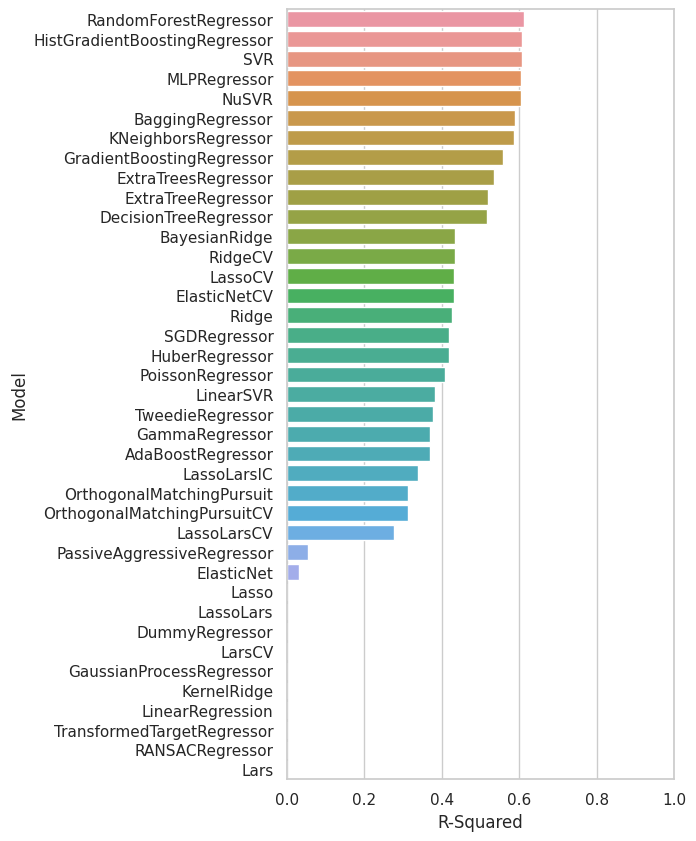

In [91]:
# Bar plot of R-squared values
#train["R-Squared"] = [0 if i < 0 else i for i in train.iloc[:,0] ]
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions.index, x="R-Squared", data=predictions)
ax.set(xlim=(0, 1))

[(0.0, 10.0)]

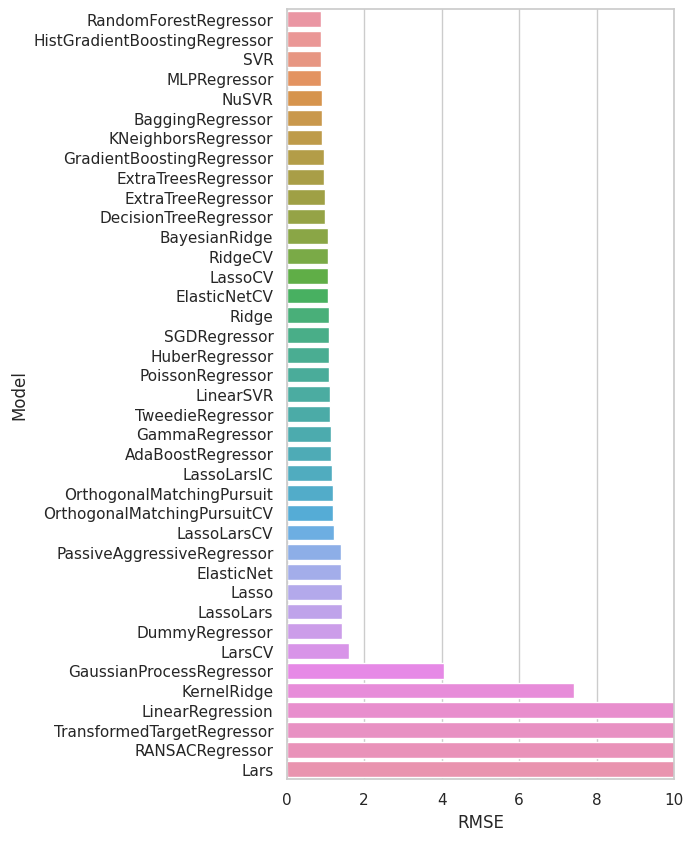

In [92]:
# Bar plot of RMSE values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions.index, x="RMSE", data=predictions)
ax.set(xlim=(0, 10))

[(0.0, 10.0)]

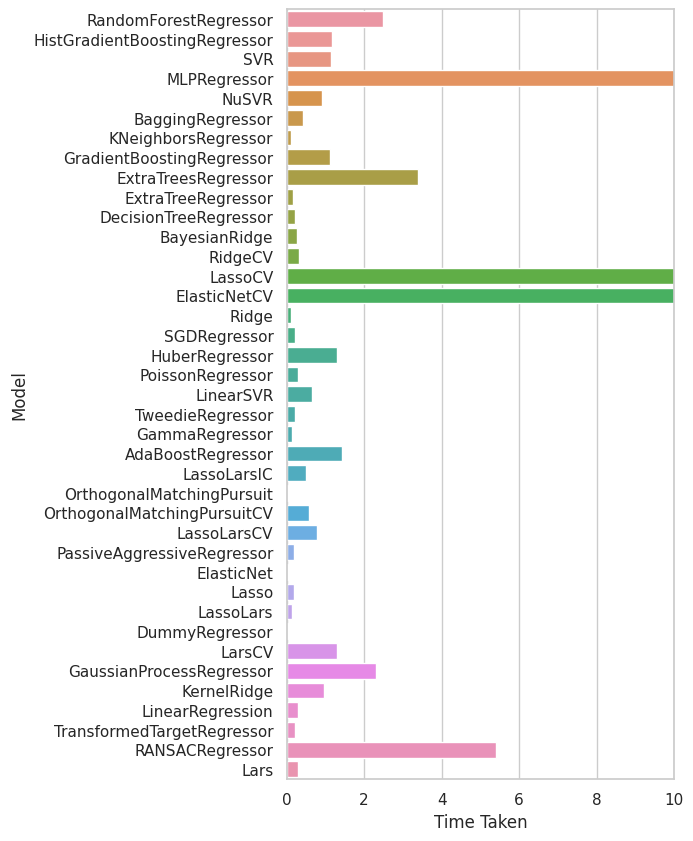

In [93]:
# Bar plot of calculation time
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions.index, x="Time Taken", data=predictions)
ax.set(xlim=(0, 10))

In [99]:
# Build the Regression Model based on the one with best overall performance (finetuning the 3 best models
# from above)
np.random.seed(100)
random_forest = RandomForestRegressor()

param_distributions = {"max_depth": [6, 5, 4, 3, None], "min_samples_split": [num for num in range(2, 11)]}
search = HalvingRandomSearchCV(random_forest, param_distributions).fit(X_train, Y_train)
search.best_params_

{'min_samples_split': 2, 'max_depth': 4}

In [100]:
Y_pred = search.predict(X_test)

In [102]:
r2 = search.score(X_test, Y_test)
r2

0.471295228753164

In [ ]:
param_distributions = {"max_depth": [5, 3, None], "min_samples_split": randint(2, 11)}

<function matplotlib.pyplot.show(close=None, block=None)>

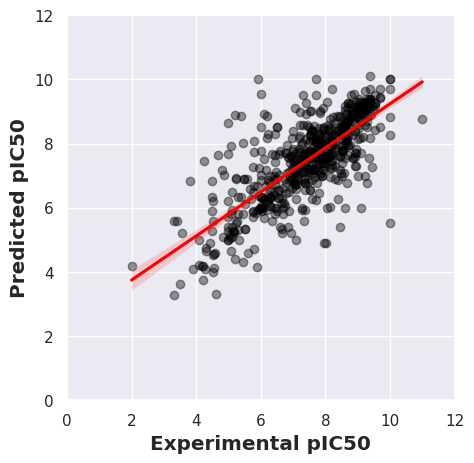

In [56]:
# Scatter Plot of Experimental vs Predicted pIC50 Values
sns.set(color_codes=True)
sns.set_style("darkgrid")

ax = sns.regplot(x=Y_test, y=Y_pred, scatter_kws={'alpha':0.4, "color": "black"}, line_kws={"color": "red"})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show

## KAT5 Fingerprints

In [ ]:
X_kat5 = df_kat5.drop('pIC50', axis=1)
X_kat5

In [ ]:
Y_kat5 = df_kat5.pIC50
Y_kat5

In [ ]:
X_kat5.shape

In [ ]:
Y_kat5.shape

In [ ]:
# Remove low variance features
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X_kat5 = selection.fit_transform(X_kat5)

In [ ]:
X_kat5.shape

In [ ]:
# Split the model into 80-20 format
X_kat5_train, X_kat5_test, Y_kat5_train, Y_kat5_test = train_test_split(X_kat5, Y_kat5, 
                                                                        test_size=0.2, random_state=42)

In [ ]:
X_kat5_train.shape, Y_kat5_train.shape

In [ ]:
X_test.shape, Y_test.shape

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f6035b11-f7b4-4c22-8497-513296c81550' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>